<a href="https://colab.research.google.com/github/tafartech/PaliGemma-turbo/blob/main/PaliGemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the environment with your kaggle credentials

In [1]:
import os
from google.colab import userdata
# Kaggle auth.
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [3]:
!pip install --upgrade tensorflow

In [4]:
!pip install -U -q keras-nlp

# Imports
Let's important Keras, KerasNLP and some helper. Remember to set the backend before you import!

In [5]:
# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"

In [6]:
import keras
import keras_nlp
import numpy as np
import PIL
import requests
import io
import matplotlib

In [7]:
keras_nlp.__version__

'0.12.0'

In [8]:
keras.config.backend()

'jax'

# Load the model from Kaggle Models
Now we can load the PaliGemma "causal language model" from the Kaggle Models hub. A causal language model is just a LLM that is ready for generation, by training with a causal mask, and running generation a token at a time in a recurrent loop.

In [9]:
keras.config.set_floatx("bfloat16")

In [10]:
pali_gemma_lm = keras_nlp.models.PaliGemmaCausalLM.from_preset(
    "pali_gemma_3b_mix_224"
)
pali_gemma_lm.summary()

100%|██████████| 861/861 [00:00<00:00, 824kB/s]
100%|██████████| 5.45G/5.45G [01:30<00:00, 64.8MB/s]
100%|██████████| 410/410 [00:00<00:00, 239kB/s]
100%|██████████| 4.07M/4.07M [00:00<00:00, 17.5MB/s]


Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)          │                                             257,152 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2048)        │   2,923,335,408 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     526,647,296 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,923,335,408 (5.45 GB)

 Trainable params: 2,923,335,408 (5.45 GB)

 Non-trainable params: 0 (0.00 B)

# Test PaliGemma Inference
We can now load a test image and start query it with the model.

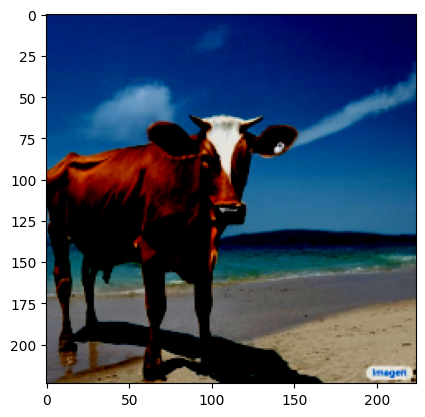

In [11]:
# Crop the image to the desired dimensions.
target_size = (224, 224)

def crop_and_resize(image, target_size):
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    return image.resize(target_size, box=(left, top, right, bottom))

def read_image(url):
    contents = io.BytesIO(requests.get(url).content)
    image = PIL.Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)
    # Remove alpha channel if neccessary.
    if image.shape[2] == 4:
        image = image[:, :, :3]
    # Scale to range [0, 1].
    return image / 127.5 - 1

image_url = 'https://storage.googleapis.com/keras-cv/models/paligemma/cow_beach_1.png'
image = read_image(image_url)
matplotlib.pyplot.imshow(image)

Here's a generation call with a single image and prompt. The prompt should always end with `\n.`

In [12]:
prompt = 'answer en where is the cow standing?\n'
output = pali_gemma_lm.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)

answer en where is the cow standing?
beach


*Here's a generation call with batched inputs.*

In [13]:
prompts = [
    'answer en where is the cow standing?\n',
    'answer en what color is the cow?\n',
    'describe en\n',
    'detect cow\n',
    'segment cow\n',
]
images = [image, image, image, image, image]
outputs = pali_gemma_lm.generate(
    inputs={
        "images": images,
        "prompts": prompts,
    }
)
for output in outputs:
    print(output)

answer en where is the cow standing?
beach
answer en what color is the cow?
brown
describe en
In this image we can see a cow standing on the sand. In the background, we can see the water, mountains and the sky.
detect cow
<loc0274><loc0000><loc1022><loc0688> cow
segment cow
<loc0278><loc0000><loc1012><loc0686><seg028><seg093><seg116><seg113><seg007><seg065><seg057><seg023><seg081><seg126><seg019><seg093><seg016><seg102><seg003><seg068>


There's a few other style of prompts this model can handle out of the box...

`"cap {lang}\n"`: very raw short caption (from WebLI-alt).

`"caption {lang}\n"`: nice, coco-like short captions.

`"describe {lang}\n"`: somewhat longer more descriptive captions.

`"ocr\n"`: optical character recognition.
`"answer en {question}\n"`: question answering about the image contents.
`"question {lang} {answer}\n"`: question generation for a given answer.

`"detect {thing} ; {thing}\n"`: count objects in a scene.

**Give it a try**